# Translate your own language

<b>Name:</b> Abhinav Lugun <b>Student Id:</b> st122322

## Introduction

In this assignment, a model was trained to translate Hindi text to English text. 'IITB-English-Hindi Parallel Corpus' was the dataset used for training the model. More information about the data can be found at https://huggingface.co/datasets/cfilt/iitb-english-hindi. Because Hindi and English texts pair are stored in a slightly different format than data used during lab, modifications are made to yield_tokens and collate_batch functions to process the format of the Hindi-Enligh Dataset. To toknenize Hindi text, 'Stanza' library from Stanford was used. More information about the library can be found at https://github.com/stanfordnlp/stanza.

In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

from datasets import load_dataset, Dataset

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [3]:
torch.__version__

'1.13.1'

In [4]:
torchtext.__version__

'0.14.1'

## 1. ETL: Loading the dataset

In [5]:
train      = load_dataset("cfilt/iitb-english-hindi", split="train", streaming=True)
validation = load_dataset("cfilt/iitb-english-hindi", split="validation", streaming=True)
test       = load_dataset("cfilt/iitb-english-hindi", split="test", streaming=True)

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91


In [6]:
train

## 2. EDA - simple investigation

In [7]:
sample = next(iter(train))
sample

{'translation': {'en': 'Give your application an accessibility workout',
  'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}}

In [8]:
for count, i in enumerate(train):
    print(i)
    if count == 4:
        break

{'translation': {'en': 'Give your application an accessibility workout', 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}}
{'translation': {'en': 'Accerciser Accessibility Explorer', 'hi': 'एक्सेर्साइसर पहुंचनीयता अन्वेषक'}}
{'translation': {'en': 'The default plugin layout for the bottom panel', 'hi': 'निचले पटल के लिए डिफोल्ट प्लग-इन खाका'}}
{'translation': {'en': 'The default plugin layout for the top panel', 'hi': 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका'}}
{'translation': {'en': 'A list of plugins that are disabled by default', 'hi': 'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है'}}


In [9]:
train_size = len(list(iter(train)))
train_size

1659083

In [10]:
val_size = len(list(iter(validation)))
val_size

520

In [11]:
test_size = len(list(iter(test)))
test_size

2507

### Scale Sampling Train Dataset

Due to the very large number of samples, only 0.01 percent of the dataset is used for faster training.

In [12]:
one_percent = int(train_size * 0.01)
one_percent

16590

In [13]:
reduced_train = []

for count, train_sample in enumerate(train):
    if count == one_percent:
        break
    reduced_train.append(train_sample)

In [14]:
reduced_train[:4]

[{'translation': {'en': 'Give your application an accessibility workout',
   'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}},
 {'translation': {'en': 'Accerciser Accessibility Explorer',
   'hi': 'एक्सेर्साइसर पहुंचनीयता अन्वेषक'}},
 {'translation': {'en': 'The default plugin layout for the bottom panel',
   'hi': 'निचले पटल के लिए डिफोल्ट प्लग-इन खाका'}},
 {'translation': {'en': 'The default plugin layout for the top panel',
   'hi': 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका'}}]

In [15]:
 from torchdata.datapipes.iter import IterableWrapper

In [16]:
reduced_train = IterableWrapper(reduced_train)

In [17]:
for count, i in enumerate(reduced_train):
    print(i)
    if count == 4:
        break

{'translation': {'en': 'Give your application an accessibility workout', 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}}
{'translation': {'en': 'Accerciser Accessibility Explorer', 'hi': 'एक्सेर्साइसर पहुंचनीयता अन्वेषक'}}
{'translation': {'en': 'The default plugin layout for the bottom panel', 'hi': 'निचले पटल के लिए डिफोल्ट प्लग-इन खाका'}}
{'translation': {'en': 'The default plugin layout for the top panel', 'hi': 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका'}}
{'translation': {'en': 'A list of plugins that are disabled by default', 'hi': 'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है'}}


In [18]:
train_size = len(list(iter(reduced_train)))
train_size

16590

## 3. Preprocessing

In [19]:
# SRC_LANGUAGE = 'en'
# TRG_LANGUAGE = 'hi'

In [20]:
import stanza

In [21]:
SRC_LANGUAGE = 'hi'
TRG_LANGUAGE = 'en'

In [22]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [23]:
stanza.download('hi')

2023-03-05 20:27:04 INFO: Downloading default packages for language: hi (Hindi) ...
2023-03-05 20:27:05 INFO: File exists: C:\Users\abhin\stanza_resources\hi\default.zip
2023-03-05 20:27:07 INFO: Finished downloading models and saved to C:\Users\abhin\stanza_resources.


In [24]:
hindi_tokenizer = stanza.Pipeline('hi', processors='tokenize', download_method=None)

def tokenizeHindiSent(text):
    doc = hindi_tokenizer(text)
    
    for sentence in doc.sentences:
        hindi_tokens = [token.text for token in sentence.tokens]
    return hindi_tokens

2023-03-05 20:27:07 INFO: Loading these models for language: hi (Hindi):
| Processor | Package |
-----------------------
| tokenize  | hdtb    |

2023-03-05 20:27:07 INFO: Use device: gpu
2023-03-05 20:27:07 INFO: Loading: tokenize
2023-03-05 20:27:13 INFO: Done loading processors!


In [25]:
from torchtext.data.utils import get_tokenizer

token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_md')
token_transform[SRC_LANGUAGE] = tokenizeHindiSent

In [26]:
sample

{'translation': {'en': 'Give your application an accessibility workout',
  'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}}

In [27]:
#example of tokenization of the english part
print("Sentence: ", sample["translation"]["en"])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample["translation"]["en"]))

Sentence:  Give your application an accessibility workout
Tokenization:  ['Give', 'your', 'application', 'an', 'accessibility', 'workout']


In [28]:
#example of tokenization of the english part
print("Sentence: ", sample["translation"]["hi"])
print("Tokenization: ", tokenizeHindiSent(sample["translation"]["hi"]))

Sentence:  अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
Tokenization:  ['अपने', 'अनुप्रयोग', 'को', 'पहुंचनीयता', 'व्यायाम', 'का', 'लाभ', 'दें']


<b>A function to tokenize our input</b>

In [29]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    print(f"Tokenizing {language}")
    
    for data_sample in data:
        if language == "en":
            yield token_transform[language](data_sample["translation"]["en"])
        elif language == "hi":
            doc = token_transform[language](data_sample["translation"]["hi"])
            for i, sentence in enumerate(doc.sentences):
                hindi_tokens = [token.text for token in sentence.tokens]
            yield hindi_tokens
    
    print(f"{language} tokenized!")

In [30]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    print(f"Tokenizing {language}")
    
    for data_sample in data:
        yield token_transform[language](data_sample["translation"][language])
    
    print(f"{language} tokenized!")

In [31]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [32]:

from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(reduced_train, ln), 
                                                    min_freq=5,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

Tokenizing hi
hi tokenized!
Tokenizing en
en tokenized!


In [33]:
len(vocab_transform['en']), len(vocab_transform['hi'])

(1863, 1768)

In [34]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[560, 50, 10, 0, 10]

In [35]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[120]

'त्रुटि'

In [36]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [37]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [38]:
#check unique vocabularies
len(mapping)

1768

In [39]:
torch.save(vocab_transform, "vocab_transform.pth")

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [40]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for batch_sample in batch:
        src_sample = batch_sample["translation"]["hi"]
        trg_sample = batch_sample["translation"]["en"]
        
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [41]:
text_transform

{'hi': <function __main__.sequential_transforms.<locals>.func(txt_input)>,
 'en': <function __main__.sequential_transforms.<locals>.func(txt_input)>}

In [42]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    print(f"Tokenizing {language}")
    
    for data_sample in data:
        yield token_transform[language](data_sample["translation"][language])
    
    print(f"{language} tokenized!")

In [43]:
batch_size = 64

train_loader = DataLoader(reduced_train, batch_size=batch_size,
                               collate_fn=collate_batch)
valid_loader = DataLoader(validation, batch_size=batch_size,
                               collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             collate_fn=collate_batch)

In [44]:
for hi, _, en in train_loader:
    break

In [45]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("Hindi shape: ", hi.shape)    # (seq len, batch_size)

English shape:  torch.Size([12, 64])
Hindi shape:  torch.Size([19, 64])


## 5. Design the model

### Encoder

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [46]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)        
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, hid dim * 2]
        #hidden = [batch size, hid dim]
        
        return outputs, hidden

### Attention

The attention used here is additive attention which is defined by:

$$e = v\text{tanh}(W_hh + W_ss + b)$$

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a `[batch size, source sentence length]` tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: `["hello", "how", "are", "you", "?", `<pad>`, `<pad>`]`, then the mask would be `[1, 1, 1, 1, 1, 0, 0]`.

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [47]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch size, src len, hid dim]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
        #energy = [batch size, src len, hid dim]
        
        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]
        
        #use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

Let's see how the masked_fill work, just so you have faith

In [48]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [49]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
            
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Putting them together (become Seq2Seq!)

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [50]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so it's the same shape as attention
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attentiont outputs from decoder
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        mask = self.create_mask(src)
        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output    = [batch size, output dim]
            #hidden    = [batch size, hid dim]
            #attention = [batch size, src len]
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #place attentions in a tensor holding attention for each token
            attentions[t] = attention
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

## 6. Training

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [51]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [52]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(1768, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(1863, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=1863, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [53]:
next(model.parameters()).is_cuda

True

In [54]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

452608
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
476928
1966080
786432
  1536
  1536
3338496
  1863
______
10703687


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [55]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

The training is very similar to part 1.

In [56]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [57]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [58]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [59]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [60]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 1m 18s
	Train Loss: 5.153 | Train PPL: 172.983
	 Val. Loss: 4.280 |  Val. PPL:  72.266
Epoch: 02 | Time: 1m 14s
	Train Loss: 3.991 | Train PPL:  54.108
	 Val. Loss: 4.095 |  Val. PPL:  60.038
Epoch: 03 | Time: 1m 14s
	Train Loss: 2.957 | Train PPL:  19.234
	 Val. Loss: 4.178 |  Val. PPL:  65.209
Epoch: 04 | Time: 1m 13s
	Train Loss: 2.132 | Train PPL:   8.431
	 Val. Loss: 3.980 |  Val. PPL:  53.543
Epoch: 05 | Time: 1m 16s
	Train Loss: 1.598 | Train PPL:   4.945
	 Val. Loss: 3.838 |  Val. PPL:  46.450
Epoch: 06 | Time: 1m 16s
	Train Loss: 1.269 | Train PPL:   3.556
	 Val. Loss: 3.875 |  Val. PPL:  48.206
Epoch: 07 | Time: 1m 16s
	Train Loss: 1.058 | Train PPL:   2.881
	 Val. Loss: 4.010 |  Val. PPL:  55.125
Epoch: 08 | Time: 1m 19s
	Train Loss: 0.879 | Train PPL:   2.408
	 Val. Loss: 4.005 |  Val. PPL:  54.889
Epoch: 09 | Time: 1m 17s
	Train Loss: 0.796 | Train PPL:   2.217
	 Val. Loss: 4.266 |  Val. PPL:  71.238
Epoch: 10 | Time: 1m 24s
	Train Loss: 0.695 | Train PPL

Text(0, 0.5, 'loss')

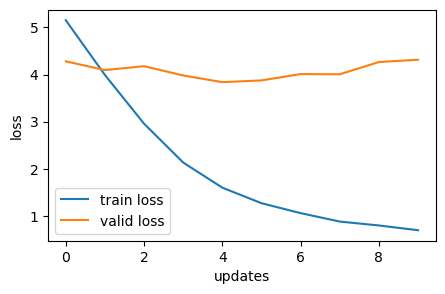

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [62]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.253 | Test PPL:  70.344 |


## 7. Test on some random news

In [63]:
hi_sample = sample["translation"]["hi"]
hi_sample

'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'

In [64]:
en_sample = sample["translation"]["en"]
en_sample

'Give your application an accessibility workout'

In [65]:
src_text = text_transform[SRC_LANGUAGE](hi_sample).to(device)
src_text

tensor([   2,  443,  137,    7,  264, 1178,    8, 1165,  451,    3],
       device='cuda:0')

In [66]:
trg_text = text_transform[TRG_LANGUAGE](en_sample).to(device)
trg_text

tensor([   2,  879,  111,  297,   42,  288, 1330,    3], device='cuda:0')

In [67]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [68]:
trg_text = trg_text.reshape(-1, 1)

In [69]:
src_text.shape, trg_text.shape

(torch.Size([10, 1]), torch.Size([8, 1]))

In [70]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [71]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [72]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([8, 1, 1863])

Since batch size is 1, we just take off that dimension

In [73]:
output = output.squeeze(1)

In [74]:
output.shape

torch.Size([8, 1863])

We shall remove the first token since it's zeroes anyway

In [75]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([7, 1863])

Then we just take the top token with highest probabilities

In [76]:
output_max = output.argmax(1) #returns max indices

In [77]:
output_max

tensor([879, 111, 297,  42,   0,  42,   0], device='cuda:0')

Get the mapping of the target language

In [78]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [79]:
for token in output_max:
    print(mapping[token.item()])

Give
your
application
an
<unk>
an
<unk>


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [80]:
attentions.shape

torch.Size([8, 1, 10])

In [81]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](hi_sample) + ['<eos>']
src_tokens

['<sos>',
 'अपने',
 'अनुप्रयोग',
 'को',
 'पहुंचनीयता',
 'व्यायाम',
 'का',
 'लाभ',
 'दें',
 '<eos>']

In [82]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>', 'Give', 'your', 'application', 'an', '<unk>', 'an', '<unk>']

In [83]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\abhin\AppData\Local\Temp\ipykernel_12772\59549304.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\abhin\AppData\Local\Temp\ipykernel_12772\59549304.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
C:\Users\abhin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\abhin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\abhin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\abhin\anaconda3\lib\site-packages\IPython\core\pylabtools.

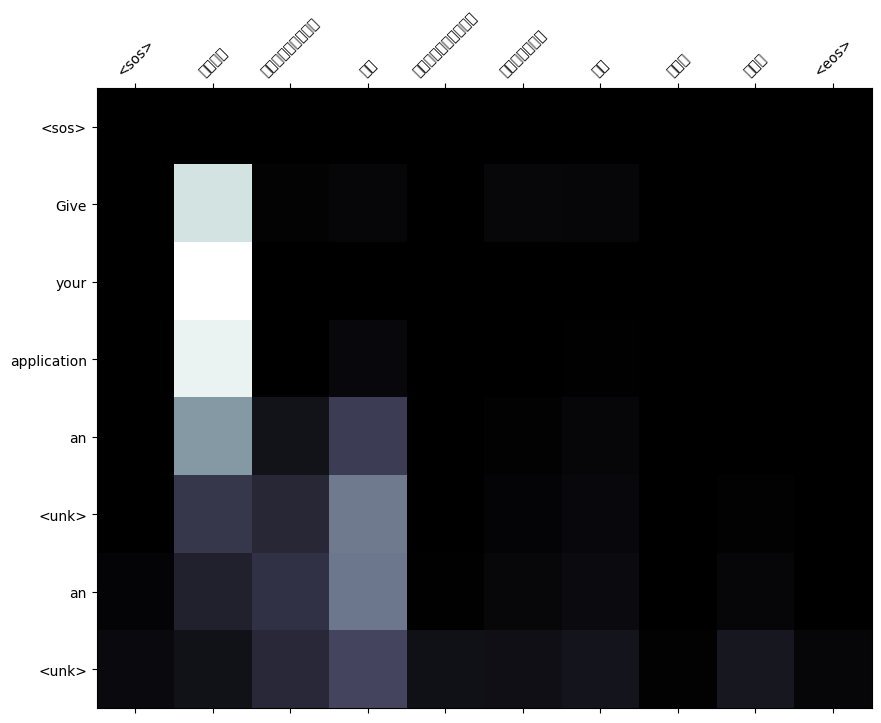

In [84]:
display_attention(src_tokens, trg_tokens, attentions)

## Conclusion

A model was trained to translate Hindi text to English text. Unfortunately, the model is not giving good results as it was also hinted by high perplexity on the validation dataset during training. This could be due to training on a much smaller sample and model not having enough capacity to learn the patterns properly